# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`
import pandas as pd
import numpy as np

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

##### Solution 10.1.1
The network diameter is defined as the longest path of the shortest paths between any two nodes. 

The p-value in this case will tell us something about the probabilty of the network diameter is random. A high value of p will mean that the network diameter is most likely random. Where a small value of p will mean that the network diamater is not random and thereby is a atribute of the network to take into account. 

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

##### Solution 10.1.2
1. The NetworkX algorithm Swap.double_edge_swap is achiving randomness by implementing a seed number, by including the seed=none we will use the global random number generator to optain randomness. The degree destribution is not changed since the function is taking 2 random edges and creates new edges for the already existing edges, thereby the degree distribution will be unchanged. 


2. nswaps is the number of  double edges swaps the function will perform, if the nswaps=2 there will be made 2 double edges swaps, which means that there will be needing 4 edges since there has to be 2 edges to perform a swap. If nswaps is high it will maybe not be possible to perform the amount of swaps requested, this will also depend on the amount of attempts the function has to swap edges. Therefore, nswaps will be the upper bound of swaps the function will perform and not the exact amount. 

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [2]:
data = pd.read_csv(
    "facebook-wall.txt.anon",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)


In [5]:
print(G.number_of_nodes())

1209


In [3]:
t0 = data.timestamp.min()  # Lower bound of time-slice (here: 7 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice

# Subset of the pandas dataframe
data_t = data.loc[data.timestamp.between(t0, t1)]

# Count the number of times each link occurs and store that in a new 'weight' column
data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

# Create a `nx.Graph` from this dataframe
G = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)

C:\Python\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Python\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


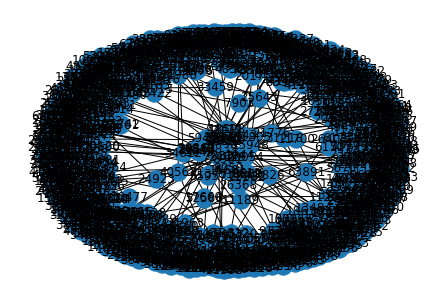

In [6]:
nx.draw(G, with_labels=True)

In [4]:
#The ALCC for the real data.

ALCC=nx.average_clustering(G)
print(ALCC)

0.10796398386235195


In [5]:
ALCC_list=[]
def swap(G):
    g=G.copy()
    g=nx.double_edge_swap(g,nswap=1000, max_tries=10000)
    return nx.average_clustering(g)

for i in range(1000):
    ALCC_list.append(swap(G))

In [6]:
#After making the list of 1000 ALCC values with 1000 double edge swaps, the average of the list is calulated.b
average = sum(ALCC_list) / len(ALCC_list)
print(average)

0.10454511199745987


In [ ]:
#The average of the list is 0.1045 which is below the true value of ALCC. 

In [7]:
#the p_val is equal to all ALCC there is above the ALCC=0.1079 from the real list
p_val=((sum(i > ALCC for i in ALCC_list))/1000)

In [8]:
p_val

0.0

In [ ]:
#I get the P-value to 0.0 and from the distribution diagram below it is possible to see that the destribution of the genereated values is no near the real data value.
#This is implying that the ALCC value in the real data is not just due to randomness. Since the real data ALCC is higher than the values for the ALCC values with random edges swaps. 

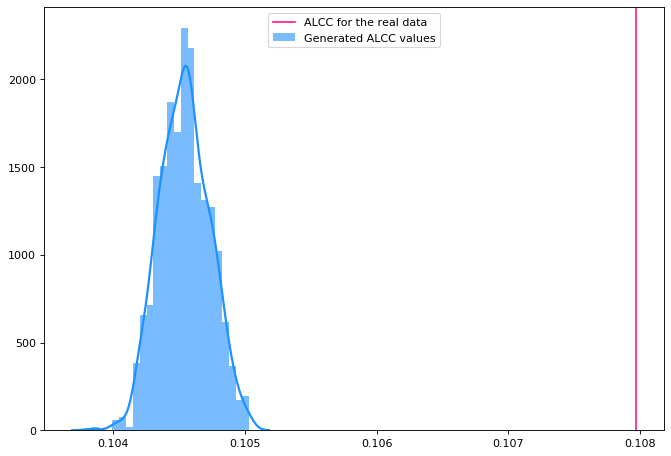

In [9]:
import seaborn as sns
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(ALCC_list, color="dodgerblue", label="Generated ALCC values", **kwargs)
plt.axvline(ALCC, 0,2500, color="deeppink", label="ALCC for the real data")
plt.legend(loc=9);

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


#### solution Ex.10.2.1

1. In the equation for modularity i and j is standing for nodes. So when there is a loop for ij in sumloop, ij is a way of writing between node i to the neighbor  node j. 


2. If the to nodes is inside the same community the deltavalue will be 1, if the to nodes is in different commununities the deltavalue will be zero, hence Q will be zero. The delta value is used to detect whether or not the to nodes is inside the same community. In code we could imply the dela value by making a function for delta, where it takes the nodes community labels into account and returns 1 if the 2 labels are in the same community and 0 otherwise. In code terms we will have $delta(c[i],c[j])$ where c[i] and c[j] are list of the communities of the nodes. First we will have to define a function 'delta thats returns 1 if the value for c_i is equal to c_j (see code below for the function for delta).  


3. This null model $\frac{k_ik_j}{2m}$ is the product of the the sum of the weights of the links attached to nodes $k_i$ and $k_j$ (hense the probability of i and j is connected) divided by the 2 times the sum of all of the links weights. This will then be the expected number of connections given the total amount of potential links 2m. 


4. We only want to take the values into account if they are in the same cluster, this is insured by the function delta. When delta is 1 the to nodes is inside the same cluster. 


5. Since m is the sum of all the edges there must be exactly 2*m nodes. So 2*m is the total amount of possible connections there can be made. 


6. The function is giving the modularity which is the sum of the actual number of edges minus the expected number of edges between node i and j. Normalized with the possible number of nodes in the data. Where only values from node in the same cluster is counting. 

In [135]:
def delta(c1,c2):
    if c1==c2:
        score=1
    else:
        score=0
    return score

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [145]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    Q=0
    m=A.sum()/2  #2m is equal m=x*1/2 the amount of edges in the network
    n=A.shape[0] #n is the number of nodes in the network
    
    for i in range(n):
        ki=A[i,:].sum() #The sum of the weights of the edges attached to node i 
        
        for j in range(n):
            kj=A[:j].sum() #The sum of the weights of the edges attached to node j
            
            Q =1/(2*m)*((A[i,j]-ki*kj/(2*m).sum()))*delta(c[i],c[j])
    return Q

In [146]:
modularity(A,c)
#I get the correct result decribed in the assignment, but it is negative.
#it is negative since A[i,j] returns zero. The answer is in the right span of values [-0.5:1],
#But if the correct answer is positive 0.122 then something is wrong. 

-0.12244897959183672

> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

In [150]:
#To find the optimal label c i have plotted the network with netwulf.
#From the plot it is easy to see that there is to clusters.
#One cluster with node 0,1,2 and one cluster with node 3,4,5
#So the optimal label would be something like c=[0,0,0,1,1,1] so all the nodes
#inside the clusters have the same label
GGG = nx.from_numpy_matrix(A)
visualize(GGG)

(None, None)

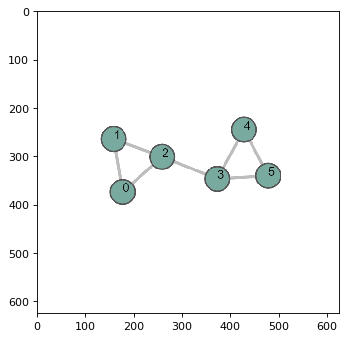

In [152]:
figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
img=mpimg.imread('Optimal_label.png')
imgplot = plt.imshow(img)
plt.show()

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

In [121]:
#I will reuse the code from last time, and make and upper and a lower treshold.  
import community

t0 = data.timestamp.max() - 86400 * 3
t1 = data.timestamp.max()      


def network_func(t0,t1):
    data_t = data.loc[data.timestamp.between(t0, t1)]

    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    return G_t


In [50]:
network_G=network_func(t0,t1)
#I cant make a combination with 5000 nodes and 20000 edges if we whant arround 5000 nodes, we will have 3 days of data, if we want
#20000 edges we want 12 days of data. I have decided to go with the 12 days. 
print('Nodes',network_G.number_of_nodes())
print('Edges',network_G.number_of_edges())

Nodes 14895
Edges 14469


> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [51]:
n_com=community.best_partition(network_G)

In [84]:
from collections import Counter

po=Counter(n_com.values())
#po is a dictionary of how many nodes there is in each cluster. 

In [132]:
#number of communities
len(po)

2385

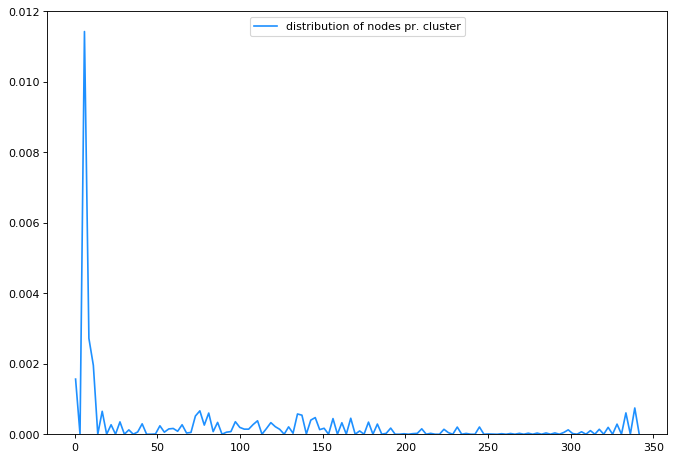

In [115]:
list_po=list(po.values())
list_po2=list(po.keys())

plt.figure(figsize=(10,7), dpi= 80)
sns.kdeplot(list_po, color="dodgerblue", label="distribution of nodes pr. cluster")
plt.legend(loc=9);

In the distribution plot it look like most of the clusters have around 1-10 nodes. Otherwise the amount of notes variates from 0-340 nodes. 

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

In [122]:
from netwulf import visualize
#To colorize the nodes by there label, we need to assign a group attribute to them for netwulf visualize to give them deffirent 
#Colors depending on there label. 
nx.set_node_attributes(network_G, n_com, 'group')

visualize(network_G)

(None, None)

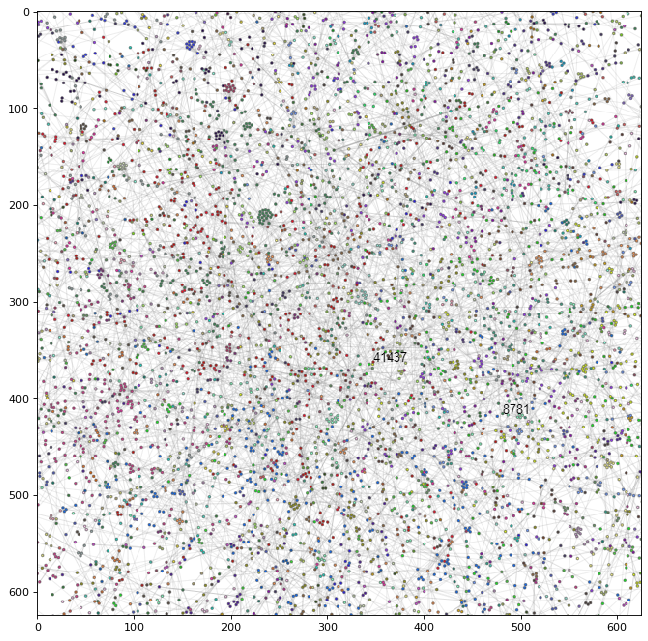

In [126]:
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
img=mpimg.imread('network_ex10.png')
imgplot = plt.imshow(img)
plt.show()

The Netwulf visualization is a bit of a mess. But the different nodes have different colors depending on there label. Some of the big clusters is visible in the plot, but it is not easy to say anything from the visualization above. 

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

As we can see in the facebook wall post network visualized above, it is very hard to make anything from the plot. 

The louvain method is decribed to work by detecting all small communities by optimizing the the modularity. All the samll comunities is then combined to one node and and new communities is detected. But from the plot it seem like there nodes is connected with many different nodes, there is not necessarily a stong bond between all the nodes in the community. This is why the visualized network looks like a mess. 

The louvian method works better with data there has a strong bond inside the community and some small bonds between communities. 

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*